In [1]:
# importation
import numpy as np
from torch.autograd import Variable
import torch
import matplotlib.pyplot as plt
%matplotlib inline
# local
from FBResNet.myfunc import Physics

In [13]:
### KALMAN FILTER #################################################################################

def Kalman_filter(y,alpha=0.1,a=1, nx=50):
    """ Comnpute nx steps of Kalman filter 
    to reconstruct the initial condition :
    obs        -- real measurement (eventually noisy) (1 x nx)
    std_dev    -- standart deviation
    """
    obs = np.flip(y)
    ### INITIALISATION
    # Construction of the observer (equal zero for the initial condition taken as parameter)
    # Moment a = 1
    if a==1:
         op_1 = 1/nx*np.ones(nx)
    # Moment a = 1/2
    if a==0.5:
         op_1 = 1/nx*np.linspace(1/nx,1,nx)**(a-1)
    #
    obs_kalman = np.vstack((op_1, np.zeros(nx))).reshape(1,2*nx)


    # Construction of the new dynamic (identity for the initial condition)
    flow = np.diag(np.ones(nx-1),-1)
    flow_kalman = np.concatenate((\
                np.concatenate((flow,np.zeros((nx,nx))),axis=1),\
                np.concatenate((np.zeros((nx,nx)),np.eye(nx)),axis=1)))

    # Construction of the norm of the two spaces
    inv_norm_obs = alpha/nx*np.eye(1)


    # Initialisation of the covariance matrix
    cov_op_m = np.kron(np.ones((2,2)),np.eye(nx))
    cov_op_p = cov_op_m.copy()

    # Initialisation of the state
    state_m = np.zeros(2*nx)
    state_p = state_m.copy()
    state_kalman = np.zeros((2*nx,nx))

    ### KALMAN FILTER
    for k in range(0,nx):

        ### CORRECTION
        # Covariance computation +
        interim_matrix = inv_norm_obs + obs_kalman.dot(cov_op_m).dot(obs_kalman.transpose())
        kalman_gain = cov_op_m.dot(obs_kalman.transpose()).dot(np.linalg.inv(interim_matrix))

        cov_op_p = (np.eye(2*nx) - kalman_gain.dot(obs_kalman)).dot(cov_op_m)\
        .dot(np.transpose((np.eye(2*nx) - kalman_gain.dot(obs_kalman)))) \
        + kalman_gain.dot(inv_norm_obs).dot(np.transpose(kalman_gain))

        # State correction computation +
        state_p = state_m + kalman_gain\
        .dot(obs[k]- np.dot(obs_kalman,state_m))
                    

        ### PREDICTION
        # Covariance computation -
        cov_op_m = flow_kalman.dot(cov_op_p).dot(flow_kalman.transpose())

        # State prediction computation -
        state_m = np.dot(flow_kalman,state_p)
        
        # Saving the solution
        state_kalman[:,k] = state_m.copy()

    return state_kalman[nx:,-1]

In [19]:
def test_gauss(noise = 0.1,alpha = 0.002, order=1, constr='cube'):
    # Gaussienne 
    physics = Physics(nx=50,m=50,a=order)
    nx    = physics.nx
    m     = physics.m
    fmax  = m//2
    t     = np.linspace(0,1,nx)
    gauss = np.exp(-(t-0.5)**2/(0.1)**(2))
    if constr == 'cube':
        gauss = gauss/np.amax(gauss)
    if constr == 'slab':
        u      = 1/nx**2*np.linspace(1,nx,nx)
        gauss = 0.5*gauss/np.dot(u,gauss)
    # obtenir les images bruitees par l' operateur d' ordre a
    # transform
    x_blurred  = physics.Compute(gauss)
    yp         = physics.BasisChange(x_blurred)
    # Etape 4 : noise 
    vn          = np.zeros(m)
    vn[fmax//2:]= np.random.randn(m-fmax//2)
    vn          = noise*np.linalg.norm(yp)*vn/np.linalg.norm(vn)
    xbn        = x_blurred + physics.BasisChangeInv(vn)
    # plot
    plt.plot(x_blurred)
    plt.plot(xbn)
    plt.show()
    #
    xp         = Kalman_filter(xbn,alpha,order,nx)
    # plot
    plt.plot(t,gauss)
    plt.plot(t,xp)
    plt.show()
    print("x-xp/x =",np.linalg.norm(xp-gauss)/np.linalg.norm(gauss))
    return xp


In [20]:
#x1 = test_gauss(noise = 0.1,alpha = 5)

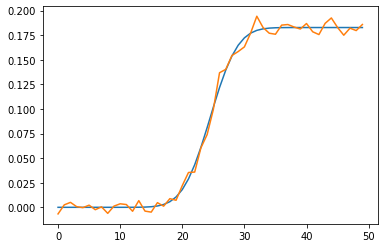

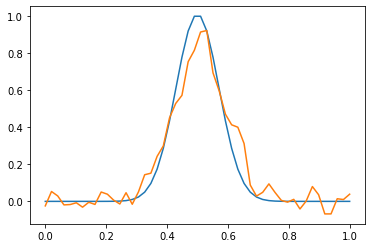

x-xp/x = 0.2202810612129819


In [30]:
x05 = test_gauss(noise = 0.05,alpha = 0.08)

In [31]:
from FBResNet.posttreat import Export_Data
from scipy.interpolate import interp1d
# interpolation
def reduce(f,n1,n2):
    t      = np.linspace(0,1,n1, endpoint=True)
    te     = np.linspace(0,1,n2,endpoint=True)
    g      = interp1d(t,f)
    f_red  = g(te)
    return te,f_red
t1,f1 = reduce(x05,50,500)
Export_Data(t1,f1,'./Redaction/data','gauss_pred_a1_kalman')

In [7]:
#x01 = test_gauss(noise = 0.01,alpha=0.5)

In [8]:
# t = np.linspace(0,1,500)
# from FBResNet.posttreat import Export_Data
# Export_Data(t,x1,'./Redaction/data','gauss_kal_a1_1')
# Export_Data(t,x05,'./Redaction/data','gauss_kal_a1_05')
# Export_Data(t,x01,'./Redaction/data','gauss_kal_a1_01')

In [9]:
#x1 = test_gauss(noise = 0.1,alpha = 5.1, order=0.5)

In [10]:
#x05 = test_gauss(noise = 0.05,alpha = 1.5)

In [11]:
#x01 = test_gauss(noise = 0.01,alpha=0.5)